In [1]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
data_path_csv = "data/mq_variants_intensity_cleaned.csv"
df = pd.read_csv(data_path_csv)

/var/folders/bf/9psf2vt14zjc1s25cdd3ll7h0000gn/T/ipykernel_95281/3177856108.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path_csv)


In [3]:
df.head()

,Variant,Variant ID,Unmod variant,Total,Total- Unmodified sequence,Variants- Unmodified sequence,Proteins,Mass,Charge,Num Mods,...,_dyn_#Baricitinib 300nM.Tech replicate 1 of 1,_dyn_#Baricitinib 300nM.Tech replicate 1 of 1_unmod,_dyn_#Baricitinib 30nM.Tech replicate 1 of 1,_dyn_#Baricitinib 30nM.Tech replicate 1 of 1_unmod,_dyn_#Baricitinib 3nM.Tech replicate 1 of 1,_dyn_#Baricitinib 3nM.Tech replicate 1 of 1_unmod,_dyn_#Baricitinib DMSO.Tech replicate 1 of 1,_dyn_#Baricitinib DMSO.Tech replicate 1 of 1_unmod,_dyn_#Baricitinib PDPD.Tech replicate 1 of 1,_dyn_#Baricitinib PDPD.Tech replicate 1 of 1_unmod
0,.IITHPNFNGNTLDNDIM+15.995LIK.,37658,.IITHPNFNGNTLDNDIMLIK.,11683,20735,81,TRYP_PIG,2299.2,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,.VADPDHDHTGFLTEYVATR.,93378,.VADPDHDHTGFLTEYVATR.,11372,15019,62,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,2144.0,2,0,...,182810000.0,182810000.0,296340000.0,296340000.0,272890000.0,272890000.0,254860000.0,254860000.0,70792000.0,70792000.0
2,.LGEHNIDVLEGNEQFINAAK.,50733,.LGEHNIDVLEGNEQFINAAK.,8878,23098,134,TRYP_PIG,2211.1,2,0,...,152910000.0,152910000.0,313690000.0,313690000.0,187600000.0,187600000.0,313290000.0,313290000.0,204790000.0,204790000.0
3,.FRHENIIGINDIIR.,25741,.FRHENIIGINDIIR.,8720,12619,33,sp|P28482-2|MK01_HUMAN;sp|P28482|MK01_HUMAN,1709.9,2,0,...,115160000.0,115160000.0,223460000.0,223460000.0,182890000.0,182890000.0,236530000.0,236530000.0,97725000.0,97725000.0
4,.ESESTAGSFSLSVR.,21292,.ESESTAGSFSLSVR.,7995,8328,7,sp|P06239-2|LCK_HUMAN;sp|P06239-3|LCK_HUMAN;sp...,1456.7,2,0,...,19220000.0,19220000.0,11216000.0,11216000.0,12721000.0,12721000.0,12835000.0,12835000.0,8137600.0,8137600.0


In [4]:
print(len(df))

83706


In [5]:
TARGET_PROTEIN = "P28482"
TARGET_DRUG = "Baricitinib"

In [6]:
df = df[df["Proteins"].str.contains(TARGET_PROTEIN)]
print(f"Found {len(df)} peptides associated with protein {TARGET_PROTEIN}.")

Found 786 peptides associated with protein P28482.


In [7]:
all_cols = df.columns.to_series()

mask_base = (
    all_cols.str.contains("_dyn_")
    & all_cols.str.contains(TARGET_DRUG)
    & ~all_cols.str.contains("unmod")
)

ctrl_mask = mask_base & all_cols.str.contains("DMSO.Tech replicate")
treat_mask = mask_base & all_cols.str.contains("nM.Tech replicate")

control_cols = all_cols[ctrl_mask].index
treatment_cols = all_cols[treat_mask].index

print(f"Control (DMSO) columns: {list(control_cols)}")
print(f"Treatment columns: {list(treatment_cols)}")

dose_pat = re.compile(rf"{TARGET_DRUG} ([^\.]+)")
doses = sorted({m.group(1) for col in treatment_cols if (m := dose_pat.search(col))})
print("Doses found:", doses)

Control (DMSO) columns: ['_dyn_#Baricitinib DMSO.Tech replicate 1 of 1']
Treatment columns: ['_dyn_#Baricitinib 1000nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 100nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 10nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 30000nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 3000nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 300nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 30nM.Tech replicate 1 of 1', '_dyn_#Baricitinib 3nM.Tech replicate 1 of 1']
Doses found: ['1000nM', '100nM', '10nM', '30000nM', '3000nM', '300nM', '30nM', '3nM']


In [ ]:
def get_log_intensities(cols: pd.Index) -> np.ndarray:
    return (
        df[cols]
        .apply(pd.to_numeric)  # Convert to numeric
        .stack()  # drop NaN values
        .pipe(np.log)  # log transform
        .values  # convert to numpy array
    )


control_intensities_log = get_log_intensities(control_cols)
dose_logs = {
    dose: get_log_intensities(
        treatment_cols[treatment_cols.str.contains(f"{TARGET_DRUG} {dose}")]
    )
    for dose in doses
}

print(f"Control (n={len(control_intensities_log)})")
for dose, log_intensities in dose_logs.items():
    print(f"{dose} (n={len(log_intensities)})")

Control (n=25)
1000nM (n=20)
100nM (n=24)
10nM (n=24)
30000nM (n=21)
3000nM (n=21)
300nM (n=21)
30nM (n=24)
3nM (n=23)


In [9]:
def run_t_tests(control: np.ndarray, dose_logs: dict):
    rows = []
    for dose, vals in dose_logs.items():
        t_stat, p_val = stats.ttest_ind(
            control, vals, equal_var=False, nan_policy="raise"
        )
        rows.append(
            {
                "dose": dose,
                "t_statistic": t_stat,
                "p_value": p_val,
            }
        )
    df = (
        pd.DataFrame(rows)
        .sort_values("p_value")
        .assign(significant=lambda d: d["p_value"] < 0.05)
    )
    return df


results_df = run_t_tests(control_intensities_log, dose_logs)
print(results_df.to_string(index=False))

if not results_df["significant"].any():
    best = results_df.iloc[0]
    print(f"No significant results; using {best.dose} (p={best.p_value:.4g})")
    significant_df = best.to_frame().T
else:
    significant_df = results_df[results_df["significant"]]

significant_doses = significant_df["dose"].tolist()

   dose  t_statistic  p_value  significant
  100nM    -0.996264 0.324228        False
   30nM    -0.805010 0.424869        False
    3nM    -0.800184 0.427730        False
   10nM    -0.795823 0.430155        False
 3000nM     0.532758 0.597119        False
  300nM    -0.396267 0.693849        False
30000nM     0.385849 0.701583        False
 1000nM    -0.021389 0.983039        False
No significant results; using 100nM (p=0.3242)


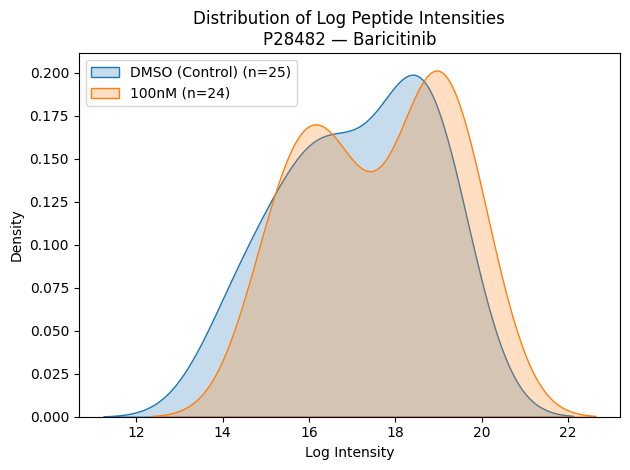

In [ ]:
sns.kdeplot(
    control_intensities_log,
    fill=True,
    label=f"DMSO (n={len(control_intensities_log)})",
)
for dose in significant_doses:
    arr = dose_logs[dose]
    sns.kdeplot(arr, fill=True, label=f"{dose} (n={len(arr)})")
plt.legend()
plt.xlabel("Log Intensity")
plt.title(f"Distribution of Log Peptide Intensities\n{TARGET_PROTEIN} — {TARGET_DRUG}")
plt.tight_layout()